In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras import initializers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import pathlib
import os
import glob

In [2]:
_DATA_SET = r"C:\Users\Rubiyet Adi\OneDrive\Desktop\OneDrive\COURSE SLIDE\10th\COMPUTER VISION AND PATTERN RECOGNITION\MID TERM\pythonJupyter\DATA_SETS\PetImages\New folder"

In [3]:
Dogs_dir = os.path.join(_DATA_SET, 'Dog')
Cats_dir = os.path.join(_DATA_SET, 'Cat')

print(len(os.listdir(Dogs_dir)))
print(len(os.listdir(Cats_dir)))


dog_image_fnames = os.listdir(Dogs_dir)
cat_image_fnames = os.listdir(Cats_dir)

11650
11741


In [4]:
_num_delete_image = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(_DATA_SET, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            _num_delete_image += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % _num_delete_image)

Deleted 0 images


In [5]:
#remove 0 size images and non jpg images

_num_image=0

for catagory in os.listdir(_DATA_SET):
    sub_dir = os.path.join(_DATA_SET, catagory)
    for name in os.listdir(sub_dir):
        fpath = os.path.join(sub_dir,name)
        if name.split('.')[1] == 'jpg':
            if os.path.getsize(fpath) <= 0:
                if os.path.isfile(fpath) == False:
                    print(fpath)
                os.remove(fpath)
            elif os.path.getsize(fpath) > 0:
                _num_image +=1
        if name.split('.')[1] != 'jpg':
            print(fpath)
            os.remove(fpath)
print(_num_image)

23391


In [6]:
batch_size = 64  # max 1000 of these images can fit in gpu memory
new_img_size = (200,200)
data_split = 0.2 #0.0005
seed_value = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    _DATA_SET,
    validation_split=data_split,
    subset="training",
    seed=seed_value,
    image_size=new_img_size,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    _DATA_SET,
    validation_split=data_split,
    subset="validation",
    seed=seed_value,
    image_size=new_img_size,
    batch_size=batch_size)

Found 23391 files belonging to 2 classes.
Using 18713 files for training.
Found 23391 files belonging to 2 classes.
Using 4678 files for validation.


In [7]:
_categories_names = train_ds.class_names
print(_categories_names)

['Cat', 'Dog']


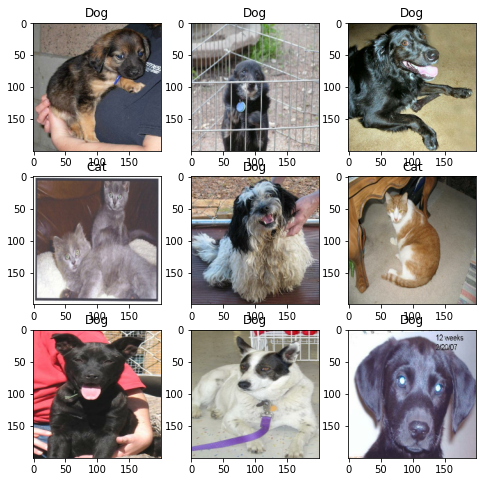

In [8]:
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(_categories_names[labels[i]])

In [9]:
model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(new_img_size[0],new_img_size[1],3)),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.35),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 200, 200, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0

In [10]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

early_stopping_callback = MyThresholdCallback(threshold=0.951)
current_working_dir = os.getcwd()

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

modelfname = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.h5'


model_folder = pathlib.Path(os.path.join(current_working_dir, 'CatsAndDogs','model'))
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_folder, modelfname), save_best_only=True, monitor='val_loss', mode='min')

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

print(logdir)
# # ======= Go to the logs folder within the current project. ===========
# # ======= Open a terminal, activate correct env, run following command to launch tensorboard
# # tensorboard --port=6007 --logdir ~/CatsAndDogs/logs
# # =====================================================================

epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback, mcp_save, early_stopping_callback]
)

#model.save(os.path.join(model_folder, modelfname))

logs\20210428-220445
Epoch 1/5
293/293 [==============================] - 876s 3s/step - loss: 0.8560 - acc: 0.5778 - val_loss: 0.8930 - val_acc: 0.5684
Epoch 2/5
293/293 [==============================] - 858s 3s/step - loss: 0.6005 - acc: 0.6776 - val_loss: 0.5695 - val_acc: 0.7118
Epoch 3/5
293/293 [==============================] - 847s 3s/step - loss: 0.5709 - acc: 0.7135 - val_loss: 0.6083 - val_acc: 0.7080
Epoch 4/5
293/293 [==============================] - 856s 3s/step - loss: 0.5395 - acc: 0.7370 - val_loss: 0.5140 - val_acc: 0.7456
Epoch 5/5
293/293 [==============================] - 830s 3s/step - loss: 0.5145 - acc: 0.7507 - val_loss: 0.5903 - val_acc: 0.7153


Text(0.5, 1.0, 'Training and validation loss')

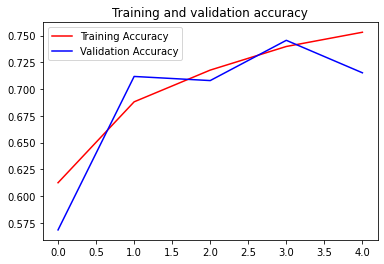

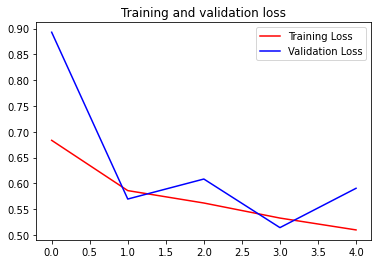

In [12]:
# PLOT LOSS AND ACCURACY

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=np.arange(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()

plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)